In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown

In [ ]:


# load PKL data
import pickle
import gdown

file_id = "1JkH1lX2K-cA4L0qvV9wRCt3GPpWYK_m3"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
file = "working_data.pkl"

gdown.download(url, file, quiet=False)
with open(file, "rb") as f:
    df = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?export=download&id=1JkH1lX2K-cA4L0qvV9wRCt3GPpWYK_m3
To: /content/working_data.pkl
100%|██████████| 11.9M/11.9M [00:00<00:00, 73.8MB/s]


In [ ]:
df['Course Level'] = (df['Number']/100).astype(int)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

# Baseline Model

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# One hot encoding for categorical data
ohe = OneHotEncoder(handle_unknown='ignore')
X_train = ohe.fit_transform(train_df[['Subject', 'Course Level', 'Sched Type', 'Primary Instructor']]).toarray()
X_test = ohe.transform(test_df[['Subject', 'Course Level', 'Sched Type', 'Primary Instructor']]).toarray()

In [ ]:
# Adding Class Size to input features
from scipy.sparse import hstack,coo_matrix
train_class_size = coo_matrix(train_df['Class Size'].values.reshape(-1,1))
test_class_size = coo_matrix(test_df['Class Size'].values.reshape(-1,1))
X_train = hstack((X_train, train_class_size), format = 'csr')
X_test = hstack((X_test, test_class_size), format = 'csr')

In [ ]:
y_train = train_df['Average GPA'].values
y_test = test_df['Average GPA'].values

In [ ]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
print(f"Baseline Model R-squared score: {model.score(X_test, y_test)}")

Baseline Model R-squared score: 0.5367592618411781


# Feature Permutation

In [ ]:
def model_with_feature_permutation(permute_column, model, train_df, y_train, y_test, permutation_times = 10):
  feature_list = ['Subject', 'Course Level', 'Sched Type', 'Primary Instructor']
  shuffle_train_df = train_df.copy()
  shuffle_test_df = test_df.copy()
  shuffle_train_df[permute_column] = np.random.permutation(shuffle_train_df[permute_column].values)
  shuffle_test_df[permute_column] = np.random.permutation(shuffle_test_df[permute_column].values)

  ohe = OneHotEncoder(handle_unknown='ignore')
  # get X,y
  X_train = ohe.fit_transform(shuffle_train_df[feature_list])
  X_test = ohe.transform(shuffle_test_df[feature_list])
  train_class_size = coo_matrix(shuffle_train_df['Class Size'].values.reshape(-1,1))
  test_class_size = coo_matrix(shuffle_test_df['Class Size'].values.reshape(-1,1))
  X_train = hstack((X_train, train_class_size), format = 'csr')
  X_test = hstack((X_test, test_class_size), format = 'csr')

  #fit model
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [ ]:
model = linear_model.LinearRegression()
score_lst = []
permute_feature = 'Subject'
for i in range(10):
  score_lst.append(model_with_feature_permutation(permute_feature, model, train_df, y_train, y_test))
print(f"Average R-squared score with shuffled {permute_feature}: {np.mean(score_lst)}")

Average R-squared score with shuffled Subject: 0.5203851106638273


In [ ]:
model = linear_model.LinearRegression()
score_lst = []
permute_feature = 'Course Level'
for i in range(10):
  score_lst.append(model_with_feature_permutation(permute_feature, model, train_df, y_train, y_test))
print(f"Average R-squared score with shuffled {permute_feature}: {np.mean(score_lst)}")

Average R-squared score with shuffled Course Level: 0.5099952194554704


In [ ]:
model = linear_model.LinearRegression()
score_lst = []
permute_feature = 'Sched Type'
for i in range(10):
  score_lst.append(model_with_feature_permutation(permute_feature, model, train_df, y_train, y_test))
print(f"Average R-squared score with shuffled {permute_feature}: {np.mean(score_lst)}")

Average R-squared score with shuffled Sched Type: 0.5323966038666859


In [ ]:
model = linear_model.LinearRegression()
score_lst = []
permute_feature = 'Primary Instructor'
for i in range(10):
  score_lst.append(model_with_feature_permutation(permute_feature, model, train_df, y_train, y_test))
print(f"Average R-squared score with shuffled {permute_feature}: {np.mean(score_lst)}")

Average R-squared score with shuffled Primary Instructor: 0.19150927478867974


In [ ]:
model = linear_model.LinearRegression()
score_lst = []
permute_feature = 'Class Size'
for i in range(10):
  score_lst.append(model_with_feature_permutation(permute_feature, model, train_df, y_train, y_test))
print(f"Average R-squared score with shuffled {permute_feature}: {np.mean(score_lst)}")

Average R-squared score with shuffled Class Size: 0.5363160529567864


## Feature Permutation summary:

From feature permutation, we found that all features contribute to the prediction, however, based on the reduction of r squared score after permutation, we can find that Primary Instructor has the greatest impact on the model. Then are the Course Level, Subject, Sched Type, and Class Size(impact decreases).

# Shapley Value

<ipython-input-15-f8b5ad410053>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  encoded_train[f'{feature}_Encoded'].fillna(global_mean_gpa, inplace=True)
<ipython-input-15-f8b5ad410053>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

Plotting SHAP summary plot...


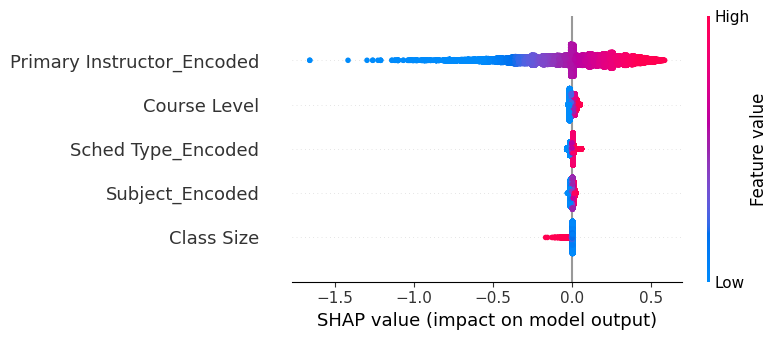

In [ ]:
import shap
from sklearn.linear_model import LinearRegression
import numpy as np

categorical_features = ['Subject', 'Sched Type', 'Primary Instructor']
numerical_features = ['Course Level', 'Class Size']

# Target encode categorical features instead of OHE
# Compute mean GPA for each category in the training set
encoded_train = train_df.copy()
encoded_test = test_df.copy()

for feature in categorical_features:
    mean_gpa = train_df.groupby(feature)['Average GPA'].mean()

    encoded_train[f'{feature}_Encoded'] = train_df[feature].map(mean_gpa)
    encoded_test[f'{feature}_Encoded'] = test_df[feature].map(mean_gpa)

    # Fill missing values (NaN) with global mean GPA
    global_mean_gpa = train_df['Average GPA'].mean()
    encoded_train[f'{feature}_Encoded'].fillna(global_mean_gpa, inplace=True)
    encoded_test[f'{feature}_Encoded'].fillna(global_mean_gpa, inplace=True)

# Combine encoded categorical and numerical features
X_train = encoded_train[[f'{feature}_Encoded' for feature in categorical_features] + numerical_features].values
X_test = encoded_test[[f'{feature}_Encoded' for feature in categorical_features] + numerical_features].values

y_train = train_df['Average GPA'].values
y_test = test_df['Average GPA'].values

model = LinearRegression()
model.fit(X_train, y_train)

# SHAP analysis
feature_names = [f'{feature}_Encoded' for feature in categorical_features] + numerical_features
explainer = shap.Explainer(model, X_train, feature_names=feature_names)
shap_values = explainer(X_test)

# Visualize SHAP results
print("Plotting SHAP summary plot...")
shap.summary_plot(shap_values, X_test)



## SHAP Summary:
As we can see from the summary plot, the higher value of primary instructor_encoded value would have higher SHAP value. Since we are using target encoding here. (i.e. each instructor is encoded by the avg gpa of that instructor) The higher avg instructor gpa it is, the higher contribution it is making to the model prediction. On the other hand it would negatively impact the model prediction when the avg instructor gpa is lower. We can easily tell from the graph that the instructor have the biggest impact on the model. The encoded subject has similar effect but it does not have that much weight compared with instructor. For course level, we can see the higher course level would have higher model impact while lower course level gpa does not affect the model that much. In terms of encoded schedule type, it does not affect the model that much compared to other features except for some of the datapoint that has high values. Lastly, larger class size would have negative impact on the model while small class size does not affect the model that much.